# Mandatory Assignemtn DAT200 2025

In [26]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures, RobustScaler, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error

In [27]:
# Import dataset
schoville_df = pd.read_csv("assets/train.csv")
schoville_df.head()

,Length (cm),Width (cm),Weight (g),Pericarp Thickness (mm),Seed Count,Capsaicin Content,Vitamin C Content (mg),Sugar Content,Moisture Content,Firmness,color,Harvest Time,Average Daily Temperature During Growth (celcius),Average Temperature During Storage (celcius),Scoville Heat Units (SHU)
0,17.37,5.42,94.30,4.90,193.93,3.21,173.59,6.15,88.59,3.40,red,Midday,8.68,5-6,0.00
1,27.78,4.75,262.71,6.56,186.29,8.19,100.41,2.36,111.20,5.45,green,Midday,22.44,NaN,0.00
2,6.17,3.51,66.72,7.96,298.81,4.69,125.91,6.75,72.98,2.77,red,Midday,24.99,NaN,455995.06
3,6.12,6.07,51.24,4.57,39.36,2.76,143.54,5.93,63.93,1.62,yellow,Midday,13.05,NaN,0.00
4,28.58,4.84,166.51,3.07,194.07,7.01,193.76,2.85,88.19,3.99,red,Midday,27.08,NaN,0.00


In [28]:
# Check dataframe properties
schoville_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 15 columns):
 #   Column                                             Non-Null Count  Dtype  
---  ------                                             --------------  -----  
 0   Length (cm)                                        999 non-null    float64
 1   Width (cm)                                         999 non-null    float64
 2   Weight (g)                                         999 non-null    float64
 3   Pericarp Thickness (mm)                            998 non-null    float64
 4   Seed Count                                         999 non-null    float64
 5   Capsaicin Content                                  999 non-null    float64
 6   Vitamin C Content (mg)                             1000 non-null   float64
 7   Sugar Content                                      999 non-null    float64
 8   Moisture Content                                   1000 non-null   float64
 9   Firmness 

In [29]:
# Check for (SHU) == 0
len(schoville_df[schoville_df['Scoville Heat Units (SHU)'] == 0])

541

Seeing so many SHU values being 0 sets off some alarms, but this just means they are normal peppers

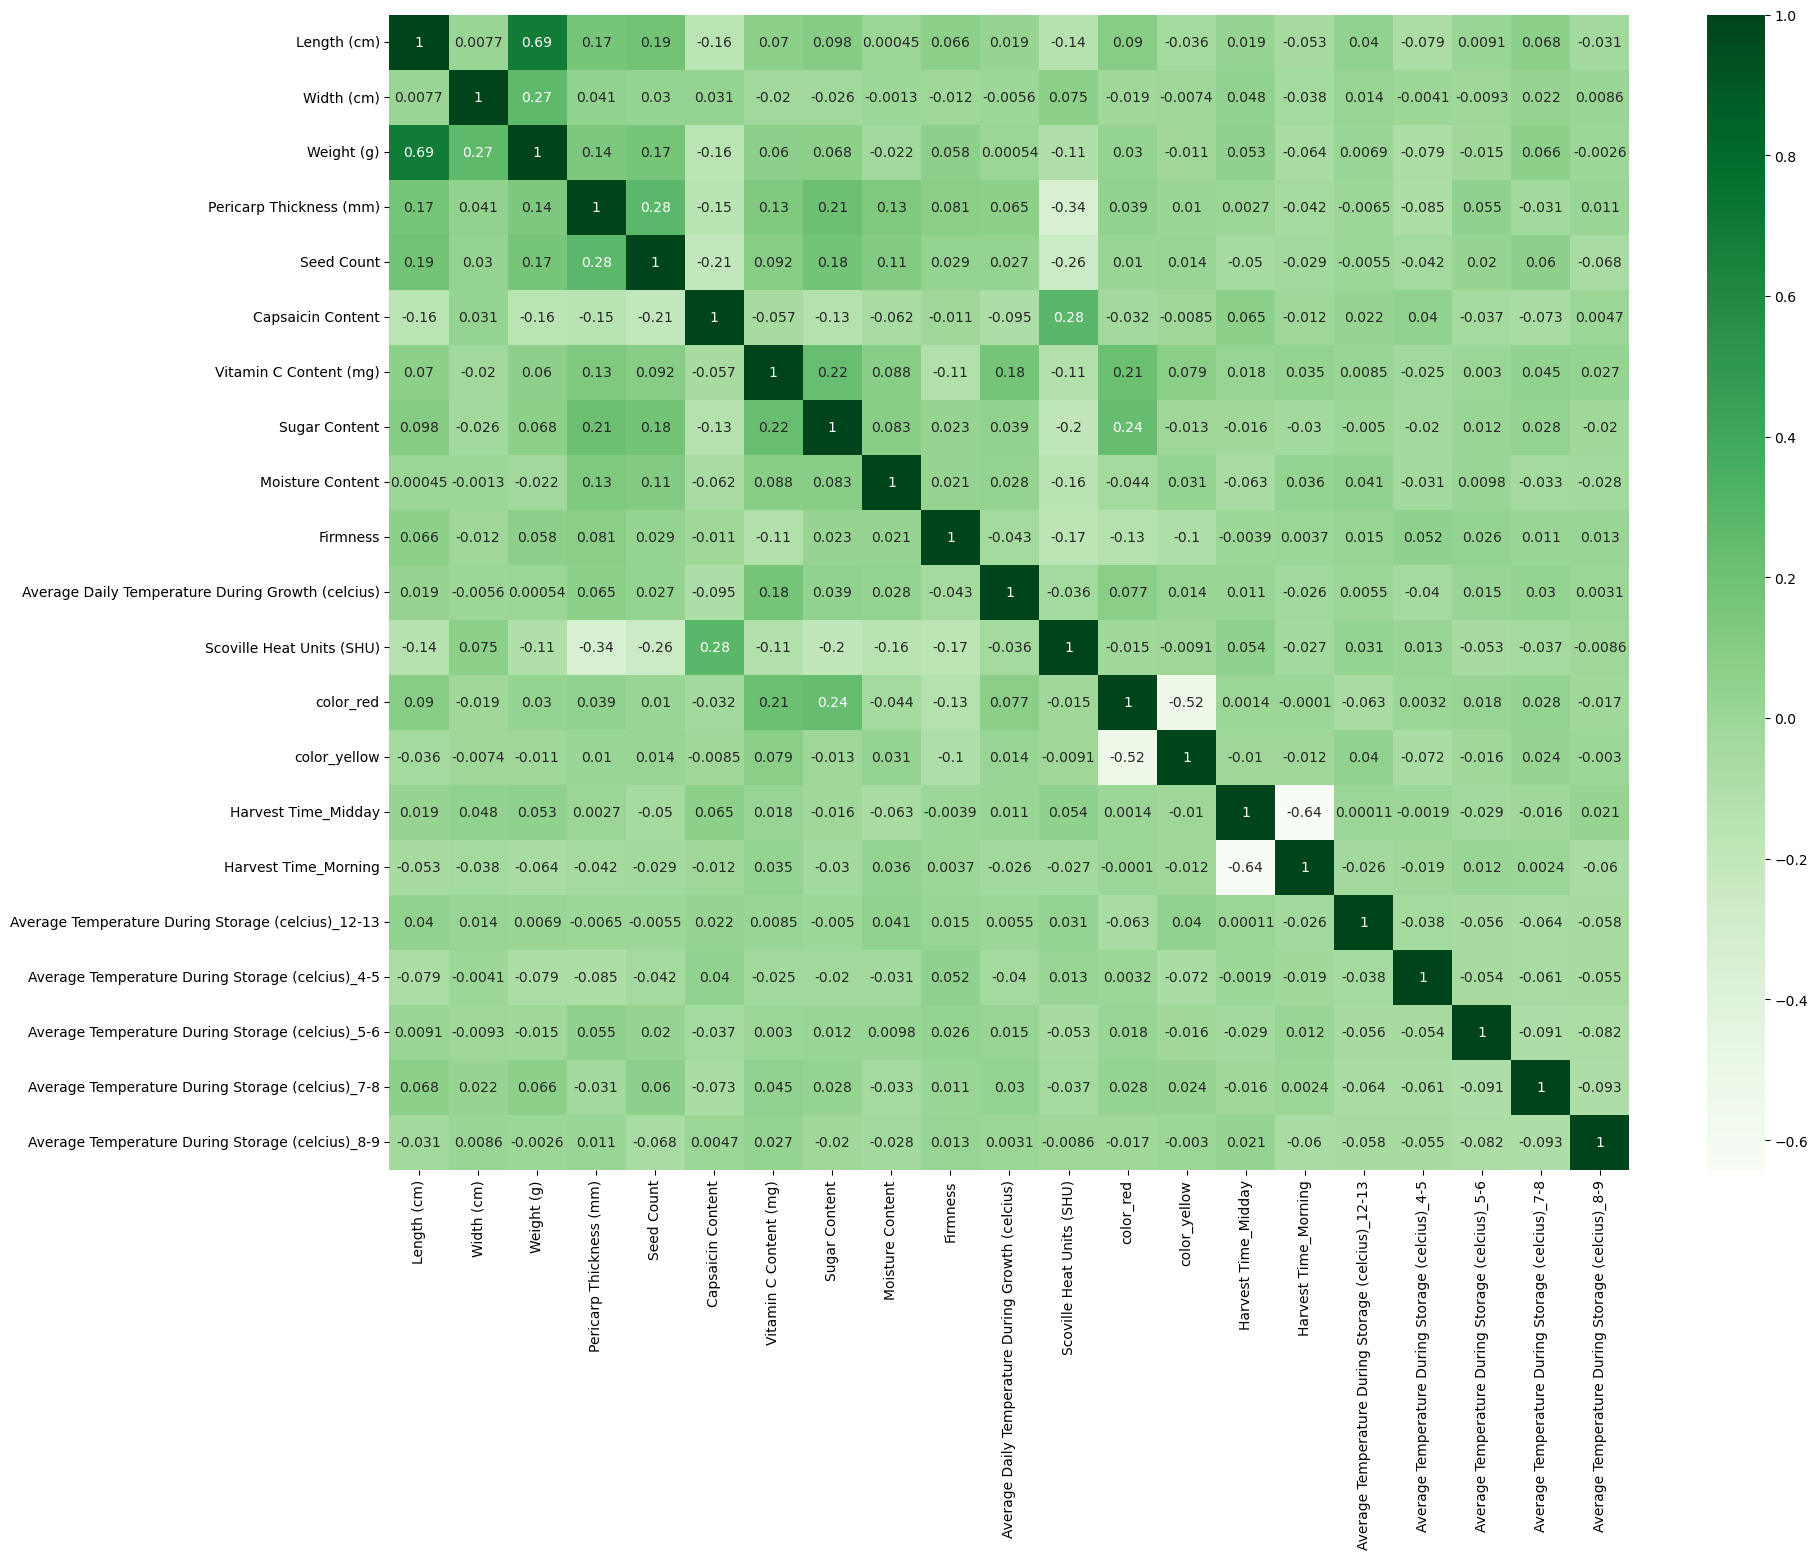

In [30]:
# Correlation matrix
schoville_dummies = pd.get_dummies(schoville_df, drop_first=True)
matrix = schoville_dummies.corr()
plt.figure(figsize=(20, 15))
sns.heatmap(matrix, cmap="Greens", annot=True)
plt.show()

By the matrix, there doesnt seem to be any obvious features to alter.

## Data preprocessing

We need to:
* Remove NaN values
* Convert to numerical values
* Check for outliers

### Remove NaN Values

Since the "Average Temperature During Storage" doesnt seem to be an obvious contributor, we'll just drop the column

In [ ]:
schoville_df = schoville_df.drop(columns=['Average Temperature During Storage (celcius)'])
schoville_df["Capsaicin2"] = schoville_df["Capsaicin Content"]**2
schoville_df["Pericarp2"] = schoville_df["Pericarp Thickness (mm)"]**2
schoville_df.head()

,Length (cm),Width (cm),Weight (g),Pericarp Thickness (mm),Seed Count,Capsaicin Content,Vitamin C Content (mg),Sugar Content,Moisture Content,Firmness,color,Harvest Time,Average Daily Temperature During Growth (celcius),Scoville Heat Units (SHU)
0,17.37,5.42,94.30,4.90,193.93,3.21,173.59,6.15,88.59,3.40,red,Midday,8.68,0.00
1,27.78,4.75,262.71,6.56,186.29,8.19,100.41,2.36,111.20,5.45,green,Midday,22.44,0.00
2,6.17,3.51,66.72,7.96,298.81,4.69,125.91,6.75,72.98,2.77,red,Midday,24.99,455995.06
3,6.12,6.07,51.24,4.57,39.36,2.76,143.54,5.93,63.93,1.62,yellow,Midday,13.05,0.00
4,28.58,4.84,166.51,3.07,194.07,7.01,193.76,2.85,88.19,3.99,red,Midday,27.08,0.00


In [32]:
schoville_df.isna().sum()

Length (cm)                                          1
Width (cm)                                           1
Weight (g)                                           1
Pericarp Thickness (mm)                              2
Seed Count                                           1
Capsaicin Content                                    1
Vitamin C Content (mg)                               0
Sugar Content                                        1
Moisture Content                                     0
Firmness                                             1
color                                                1
Harvest Time                                         0
Average Daily Temperature During Growth (celcius)    0
Scoville Heat Units (SHU)                            0
dtype: int64

In [33]:
def load_data(file_path):
    return pd.read_csv(file_path)

def build_preprocessor(numeric_cols, categorical_cols, scaler='standard'):
    if scaler == 'robust':
        num_scaler = RobustScaler()
    else:
        num_scaler = StandardScaler()
    preproc = ColumnTransformer([
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', num_scaler)
        ]), numeric_cols),
        ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
            ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
        ]), categorical_cols)
    ])
    return preproc

def clip_outliers(df, threshold=5):
    df_clip = df.copy()
    for col in df_clip.select_dtypes(include=['number']).columns:
        lower = df_clip[col].mean() - threshold * df_clip[col].std()
        upper = df_clip[col].mean() + threshold * df_clip[col].std()
        df_clip[col] = df_clip[col].clip(lower, upper)
    return df_clip

def target_transform(y):
    return np.log1p(y)

def target_inverse(y_t):
    return np.expm1(y_t)

## Pipeline and Models

### Pipeline A

In [34]:
def build_and_evaluate_pipeline_A(
    data_path, scaler='standard', thresh=5,
    degrees=[1,2], alphas=[1e-4,1e-3,1e-2,1e-1,1], l1_ratios=[0.1,0.5,0.9]
):
    df = load_data(data_path)
    X = df.drop('Scoville Heat Units (SHU)', axis=1)
    y = df['Scoville Heat Units (SHU)']
    num_cols = X.select_dtypes(np.number).columns
    cat_cols = X.select_dtypes(exclude=[np.number]).columns

    pipe = Pipeline([
        ('clean', FunctionTransformer(clip_outliers, kw_args={'threshold':thresh}, validate=False)),
        ('prep', build_preprocessor(num_cols, cat_cols, scaler)),
        ('poly', PolynomialFeatures(include_bias=False)),
        ('reg', ElasticNet(max_iter=200000))
    ])
    grid = GridSearchCV(pipe, {
        'poly__degree': degrees,
        'reg__alpha': alphas,
        'reg__l1_ratio': l1_ratios
    }, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
    y_log = target_transform(y)
    grid.fit(X, y_log)
    best = grid.best_estimator_

    scores = cross_val_score(best, X, y_log, cv=5,
                             scoring='neg_mean_absolute_error', n_jobs=-1)
    mae_log = -np.mean(scores)

    mae_orig = mean_absolute_error(y, target_inverse(best.predict(X)))

    print('Best params:', grid.best_params_)
    print('CV MAE (log):', mae_log)
    print('Train MAE:', mae_orig)
    return grid


grid_A = build_and_evaluate_pipeline_A('assets/train.csv', scaler='robust')

Best params: {'poly__degree': 2, 'reg__alpha': 0.1, 'reg__l1_ratio': 0.9}
CV MAE (log): 3.124811920986324
Train MAE: 83256.89560509313


In [35]:
def predict_pipeline_A(test_df, grid):
    for c in test_df.select_dtypes(exclude=[np.number]):
        test_df[c] = test_df[c].astype('category').cat.codes
    test_df = clip_outliers(test_df, threshold=5)
    preds_log = grid.best_estimator_.predict(test_df)
    return target_inverse(preds_log)

test_df = load_data('assets/test.csv')
preds = predict_pipeline_A(test_df, grid_A)
output_df = pd.DataFrame({'Scoville Heat Units (SHU)': preds}, index=test_df.index)
output_df.index.name = 'index'
output_df.to_csv('assets/test_predictions_A.csv')
print("Saved assets/test_predictions_A.csv")

Saved assets/test_predictions_A.csv


### Approach C

In [36]:
def train_approach_C(train_path, use_poly=False, degree=2, scaler='standard', thresh=5):
    df = load_data(train_path)
    X = df.drop('Scoville Heat Units (SHU)', axis=1)
    y = df['Scoville Heat Units (SHU)']

    y_bin = (y > 0).astype(int)

    num_cols = X.select_dtypes(include=[np.number]).columns
    cat_cols = X.select_dtypes(exclude=[np.number]).columns

    base_prep = build_preprocessor(num_cols, cat_cols, scaler)
    if use_poly:
        prep = Pipeline([('prep', base_prep),
                         ('poly', PolynomialFeatures(degree=degree, include_bias=False))])
    else:
        prep = base_prep


    clf_pipe = Pipeline([('prep', prep),
                         ('clf', RandomForestClassifier(random_state=42))])
    clf_params = {
        'clf__n_estimators': [50,100,150],
        'clf__max_depth': [None,10,20]
    }
    clf_search = GridSearchCV(clf_pipe, clf_params,
                              cv=5, scoring='f1_macro', n_jobs=-1, refit=True)
    clf_search.fit(X, y_bin)
    f1 = np.mean(cross_val_score(clf_search.best_estimator_, X, y_bin,
                                  cv=5, scoring='f1_macro', n_jobs=-1))
    print('Pipeline C classifier F1_macro:', f1)

    mask = y > 0
    X_s, y_s = X[mask], y[mask]
    y_s_log = target_transform(y_s)

    reg_pipe = Pipeline([('prep', prep),
                         ('reg', ElasticNet(max_iter=1_000_000, tol=1e-5))])
    reg_params = {
        'reg__alpha': np.logspace(-5,2,8),
        'reg__l1_ratio': [0,0.1,0.5,0.9,1]
    }
    reg_search = GridSearchCV(reg_pipe, reg_params,
                              cv=5, scoring='neg_mean_absolute_error', n_jobs=-1, refit=True)
    reg_search.fit(X_s, y_s_log)
    mae = -np.mean(cross_val_score(reg_search.best_estimator_, X_s, y_s_log,
                                    cv=5, scoring='neg_mean_absolute_error', n_jobs=-1))
    print('Pipeline C regressor MAE (log):', mae)
    print(clf_search.best_params_)
    print(reg_search.best_params_)

    return clf_search, reg_search


def predict_approach_C(test_df, clf_model, reg_model):
    y_bin = clf_model.best_estimator_.predict(test_df)
    y_reg_log = reg_model.best_estimator_.predict(test_df)
    y_reg = target_inverse(y_reg_log)
    return np.where(y_bin==0, 0, y_reg)

clf_C, reg_C = train_approach_C('assets/train.csv', use_poly=True, degree=2, scaler='robust')

Pipeline C classifier F1_macro: 0.8709573896557092


/usr/lib/python3/dist-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.465e+01, tolerance: 5.214e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/usr/lib/python3/dist-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.287e+01, tolerance: 4.156e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV in

Pipeline C regressor MAE (log): 0.7787435204093615
{'clf__max_depth': None, 'clf__n_estimators': 150}
{'reg__alpha': 1.0, 'reg__l1_ratio': 0}


/usr/lib/python3/dist-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.197e+02, tolerance: 5.408e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


## Predict the test sets

In [37]:
test_df = load_data('assets/test.csv')
for col in test_df.select_dtypes(exclude=['number']).columns:
    test_df[col] = test_df[col].astype('category').cat.codes
test_df = clip_outliers(test_df, threshold=5)
preds = predict_approach_C(test_df, clf_C, reg_C)
output_df = pd.DataFrame({'Scoville Heat Units (SHU)': preds}, index=test_df.index)
output_df.index.name = 'index'
output_df.to_csv('assets/test_predictions_C.csv')
print("Saved assets/test_predictions_C.csv")

Saved assets/test_predictions_C.csv
